## With EDA 1 It gaves us a hint that with PCA the activities are spatially sepearted with static activities towards the left and dynamic activities towards the right. Based on this knowledge we have used a different set of labels[sleep, light, sedentary, moderate-vigorous] to hide away the heirarchy.

In [1]:
cd /Users/akashmurali/Documents/capstone/project

/Users/akashmurali/Documents/capstone/project


In [2]:
import pandas as pd
import os

# load as a df
df_147 = pd.read_csv("capture24/P147.csv", index_col="time", parse_dates=["time"], dtype={'x': 'f4', 'y': 'f4', 'z': 'f4', 'annotation': 'string'})

In [3]:
# load annotation-label-dictionary.csv as df to remap the annotation to proper labels
annotation_df = pd.read_csv("capture24/annotation-label-dictionary.csv", index_col = "annotation", dtype = "string")
annotation_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 206 entries, 7030 sleeping;MET 0.95 to vehicle;MET 1.3
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   label:WillettsSpecific2018  206 non-null    string
 1   label:WillettsMET2018       206 non-null    string
 2   label:DohertySpecific2018   206 non-null    string
 3   label:Willetts2018          206 non-null    string
 4   label:Doherty2018           206 non-null    string
 5   label:Walmsley2020          206 non-null    string
dtypes: string(6)
memory usage: 11.3+ KB


In [16]:
annotation_df.head()

,label:WillettsSpecific2018,label:WillettsMET2018,label:DohertySpecific2018,label:Willetts2018,label:Doherty2018,label:Walmsley2020
annotation,,,,,,
7030 sleeping;MET 0.95,sleep,sleep,sleep,sleep,sleep,sleep
occupation;office and administrative support;11580 office/computer work general;MET 1.5,sitting,sitstand+lowactivity,sedentary-screen,sit-stand,sedentary,sedentary
home activity;household chores;preparing meals/cooking/washing dishes;5035 kitchen activity general cooking/washing/dishes/cleaning up;MET 3.3,household-chores,sitstand+activity,tasks-moderate,mixed,moderate,light
occupation;office and administrative support;11580 office wok/computer work general;MET 1.5,sitting,sitstand+lowactivity,sedentary-screen,sit-stand,sedentary,sedentary
home activity;miscellaneous;sitting;9060 sitting/lying reading or without observable/identifiable activities;MET 1.3,sitting,sitstand+lowactivity,sedentary-non-screen,sit-stand,sedentary,sedentary


In [4]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [5]:
# Direct mapping
df_147['activity_label'] = df_147['annotation'].map(annotation_df['label:Walmsley2020'])

# Check for unmapped
print(f"Unmapped rows: {df_147['activity_label'].isna().sum()}")

Unmapped rows: 2788381


In [6]:
df_147['activity_label'].nunique()

4

In [7]:
from tqdm import tqdm
import numpy as np

def extract_windows(data, winsize='10s'):
    X, Y = [], []
    for t, w in tqdm(data.resample(winsize, origin='start')):

        # Check window has no NaNs and is of correct length
        if w.isna().any().any() or len(w) != 1000:
            continue

        x = w[['x', 'y', 'z']].to_numpy()
        y = w['activity_label'].mode(dropna=False).item()

        X.append(x)
        Y.append(y)

    X = np.stack(X)
    Y = np.stack(Y)

    return X, Y

In [8]:
X, Y =extract_windows(df_147)

100%|██████████| 9721/9721 [00:02<00:00, 4426.83it/s]


In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


def apply_pca_visualization(X, Y, n_components=2):
    """
    Apply PCA to visualize activity clusters in 2D
    
    Parameters:
    -----------
    X : np.array
        Shape (n_windows, 1000, 3) - windowed acceleration data
    Y : np.array
        Shape (n_windows,) - activity labels
    
    Returns:
    --------
    plotly figure
    """
    # Flatten each window into a feature vector
    # From (n_windows, 1000, 3) to (n_windows, 3000)
    X_flattened = X.reshape(X.shape[0], -1)
    
    print(f"Original shape: {X.shape}")
    print(f"Flattened shape: {X_flattened.shape}")
    
    # Standardize features (PCA needs normalization)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_flattened)
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    # Create dataframe for plotting
    df_pca = pd.DataFrame({
        'PC1': X_pca[:, 0],
        'PC2': X_pca[:, 1],
        'Activity': Y
    })
    
    # Print explained variance
    explained_var = pca.explained_variance_ratio_
    print(f"\nExplained variance ratio:")
    for i, var in enumerate(explained_var):
        print(f"  PC{i+1}: {var*100:.2f}%")
    print(f"  Total: {sum(explained_var)*100:.2f}%")
    
    # Create visualization
    fig = px.scatter(
        df_pca,
        x='PC1',
        y='PC2',
        color='Activity',
        title=f'PCA: Activity Clustering <br>Explained Variance: PC1={explained_var[0]*100:.1f}%, PC2={explained_var[1]*100:.1f}%',
        labels={'PC1': f'PC1 ({explained_var[0]*100:.1f}%)', 
                'PC2': f'PC2 ({explained_var[1]*100:.1f}%)'},
        opacity=0.6,
        height=600
    )
    
    fig.update_traces(marker=dict(size=5))
    
    return fig, pca, df_pca

# Apply 2D PCA
fig_2d, pca_model, df_pca = apply_pca_visualization(X, Y, n_components=2)
fig_2d.show()

Original shape: (6826, 1000, 3)
Flattened shape: (6826, 3000)

Explained variance ratio:
  PC1: 31.17%
  PC2: 28.30%
  Total: 59.47%


#### the seperation is much more evident with by hiding way the heirarchy.|

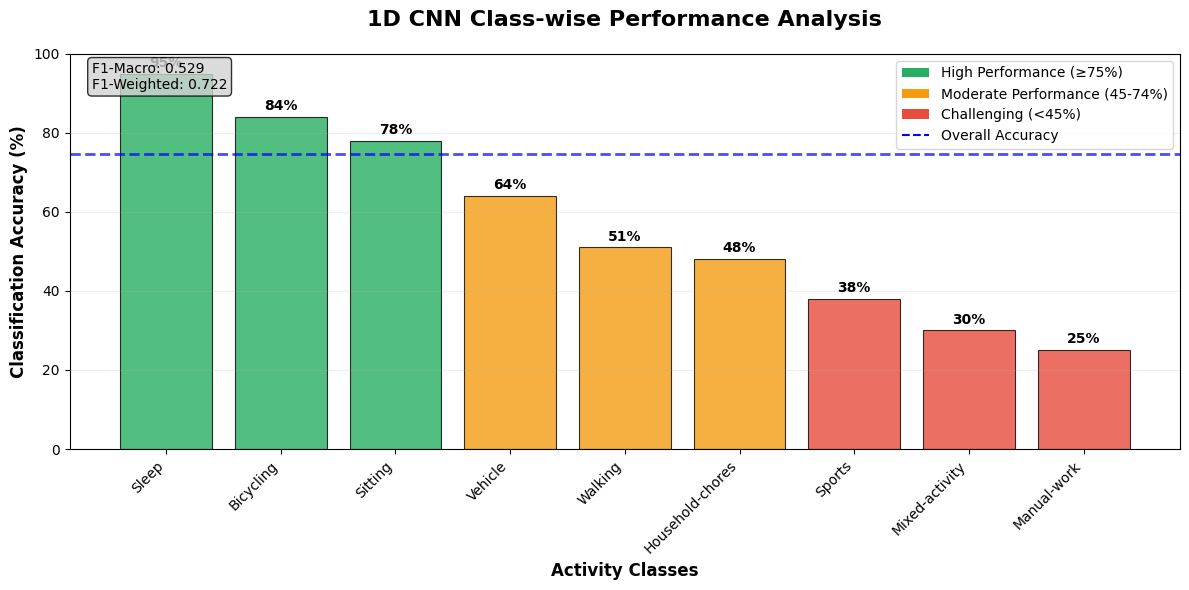

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your results
activities = ['Sleep', 'Bicycling', 'Sitting', 'Vehicle', 'Walking', 
              'Household-chores', 'Sports', 'Mixed-activity', 'Manual-work']
accuracies = [95, 84, 78, 64, 51, 48, 38, 30, 25]  # Manual-work estimated

# Color coding based on performance tiers
colors = []
for acc in accuracies:
    if acc >= 75:
        colors.append('#27ae60')  # High performing - Green
    elif acc >= 45:
        colors.append('#f39c12')  # Moderate performing - Orange  
    else:
        colors.append('#e74c3c')  # Challenging - Red

# Create the plot
plt.figure(figsize=(12, 6))
bars = plt.bar(activities, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=0.8)

# Add value labels on top of bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{acc}%', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Customize the plot
plt.title('1D CNN Class-wise Performance Analysis', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Activity Classes', fontsize=12, fontweight='bold')
plt.ylabel('Classification Accuracy (%)', fontsize=12, fontweight='bold')
plt.ylim(0, 100)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add horizontal line at overall accuracy
plt.axhline(y=74.55, color='blue', linestyle='--', alpha=0.7, linewidth=2, 
            label='Overall Validation Accuracy (74.55%)')

# Add legend for performance tiers
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#27ae60', label='High Performance (≥75%)'),
    Patch(facecolor='#f39c12', label='Moderate Performance (45-74%)'),
    Patch(facecolor='#e74c3c', label='Challenging (<45%)'),
    plt.Line2D([0], [0], color='blue', linestyle='--', label='Overall Accuracy')
]
plt.legend(handles=legend_elements, loc='upper right')

# Add F1 scores as text box
textstr = f'F1-Macro: 0.529\nF1-Weighted: 0.722'
props = dict(boxstyle='round', facecolor='lightgray', alpha=0.8)
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

plt.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

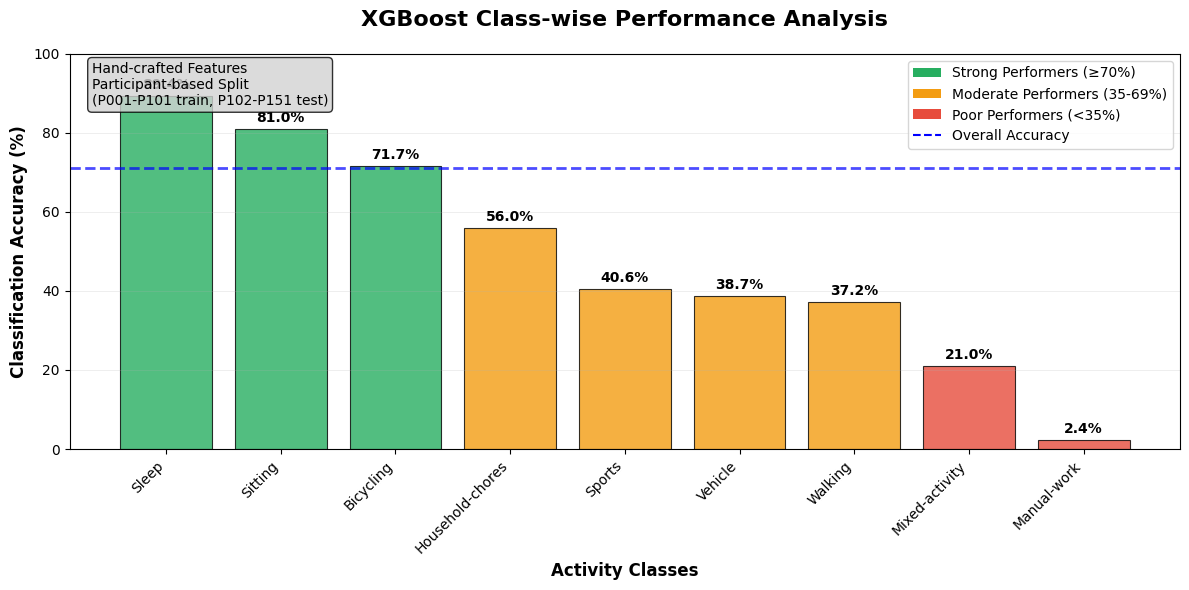

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your XGBoost results
activities = ['Sleep', 'Sitting', 'Bicycling', 'Household-chores', 'Sports', 
              'Vehicle', 'Walking', 'Mixed-activity', 'Manual-work']
accuracies = [89.4, 81.0, 71.7, 56.0, 40.6, 38.7, 37.2, 21.0, 2.4]

# Color coding based on performance tiers
colors = []
for acc in accuracies:
    if acc >= 70:
        colors.append('#27ae60')  # Strong performers - Green
    elif acc >= 35:
        colors.append('#f39c12')  # Moderate performers - Orange  
    else:
        colors.append('#e74c3c')  # Poor performers - Red

# Create the plot
plt.figure(figsize=(12, 6))
bars = plt.bar(activities, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=0.8)

# Add value labels on top of bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{acc}%', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Customize the plot
plt.title('XGBoost Class-wise Performance Analysis', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Activity Classes', fontsize=12, fontweight='bold')
plt.ylabel('Classification Accuracy (%)', fontsize=12, fontweight='bold')
plt.ylim(0, 100)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add horizontal line at overall accuracy (71% from your paper)
plt.axhline(y=71, color='blue', linestyle='--', alpha=0.7, linewidth=2, 
            label='Overall Test Accuracy (71%)')

# Add legend for performance tiers
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#27ae60', label='Strong Performers (≥70%)'),
    Patch(facecolor='#f39c12', label='Moderate Performers (35-69%)'),
    Patch(facecolor='#e74c3c', label='Poor Performers (<35%)'),
    plt.Line2D([0], [0], color='blue', linestyle='--', label='Overall Accuracy')
]
plt.legend(handles=legend_elements, loc='upper right')

# Add note about feature-based approach
textstr = 'Hand-crafted Features\nParticipant-based Split\n(P001-P101 train, P102-P151 test)'
props = dict(boxstyle='round', facecolor='lightgray', alpha=0.8)
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

plt.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()